### So till now what i observed was that the basic linear and non linear methods are unable to achive good performace on this complex EEG dataset so what i observed that because of the figure that was given in the task something new could be done in order to achive good performance so I will now apply GNN's and observe what happened as a novelty

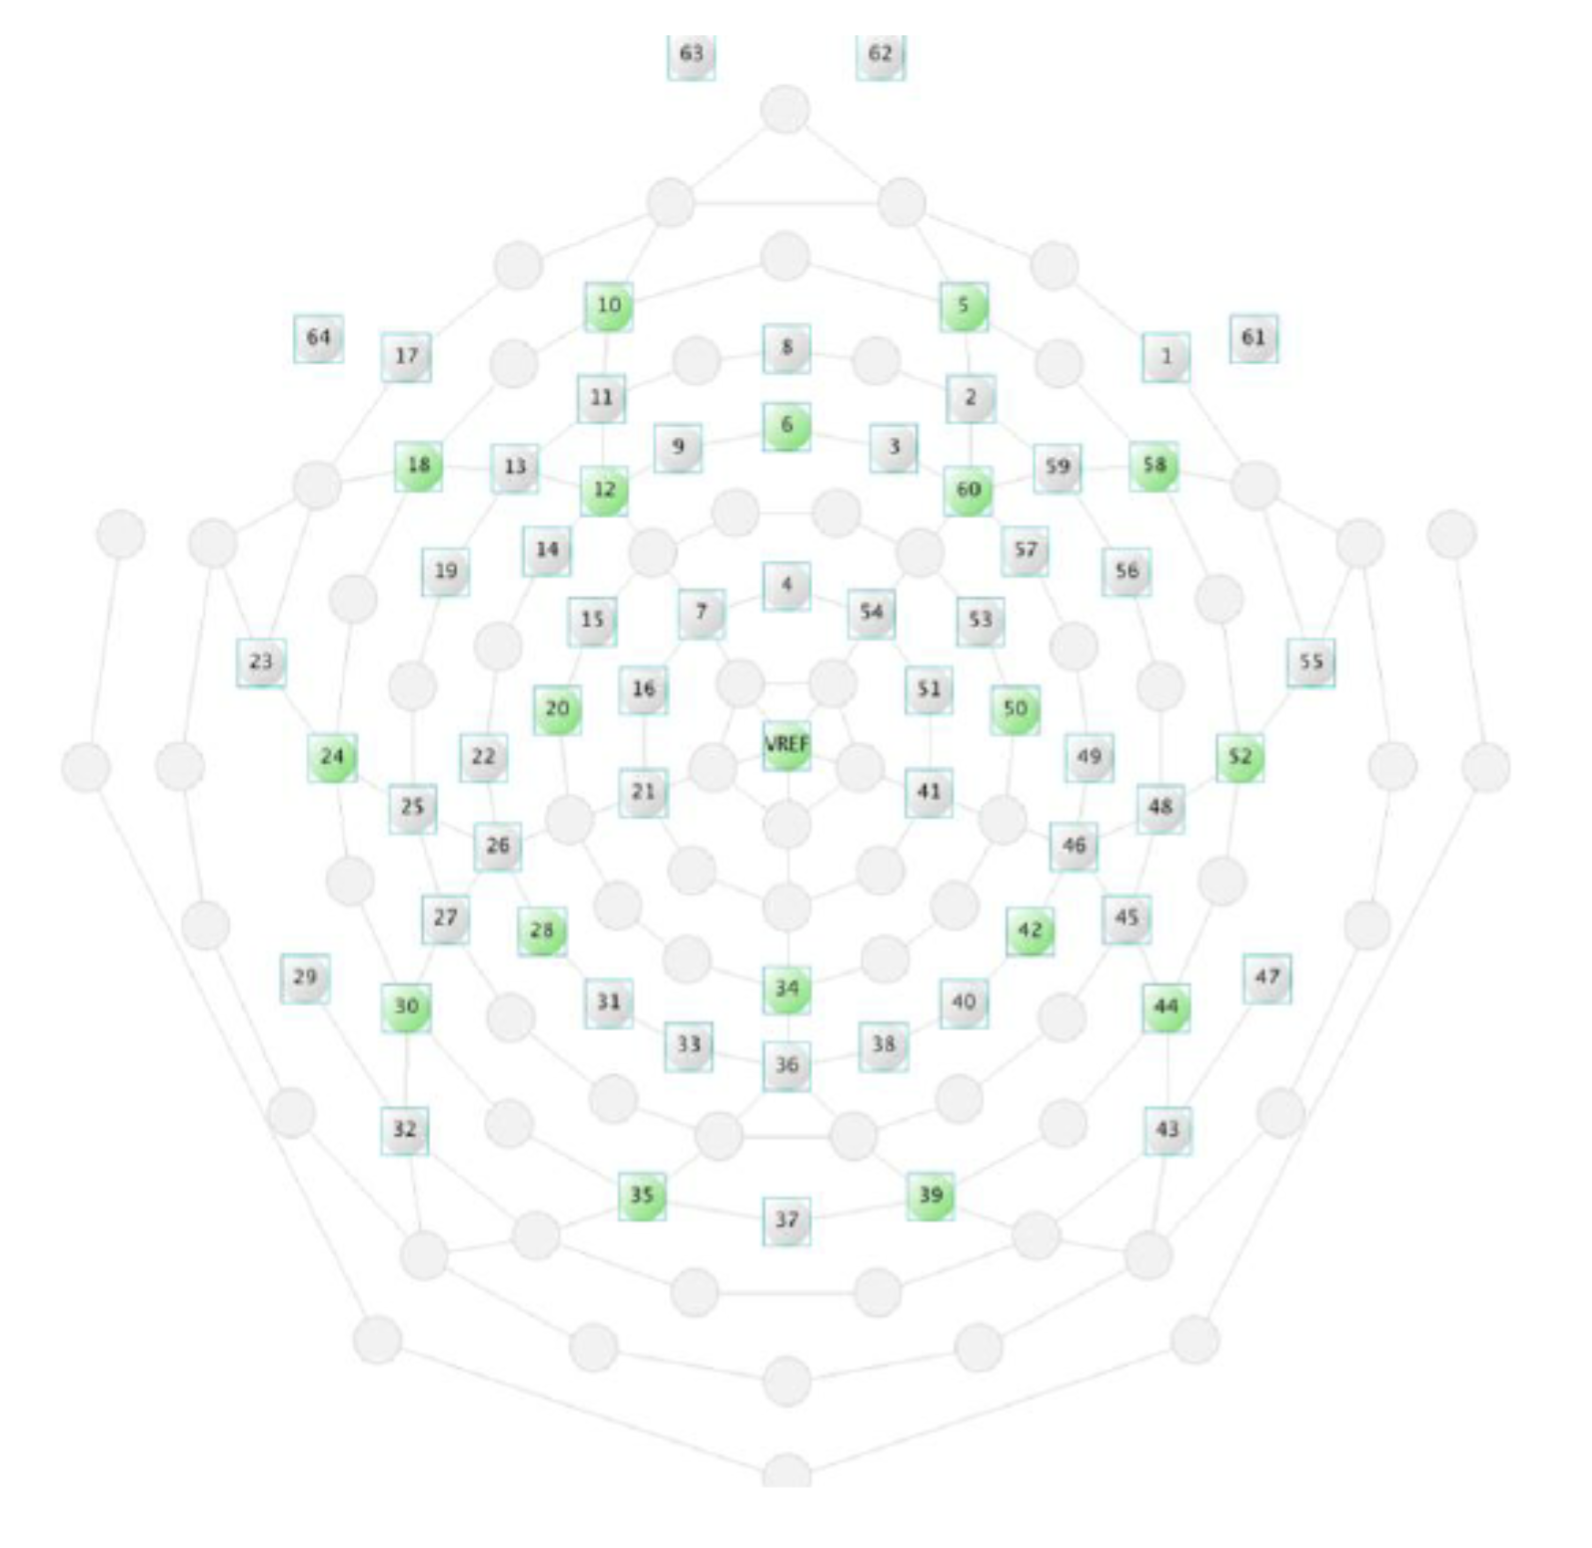

# GNN

In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Load and preprocess the data
def load_and_preprocess_data(file_path='../data/EEG data.csv'):
    # Load the data
    data = pd.read_csv(file_path)
    
    # Extract features and target
    X = data.iloc[:, 1:-1].values  # All columns except first (index) and last (target)
    y = data.iloc[:, -1].values    # Last column is the target
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

# Define the electrode adjacency based on the EEG montage
def create_electrode_adjacency():
    # Define number of electrodes
    num_electrodes = 64
    
    # Create a dictionary to represent the adjacency structure based on the image
    # For each electrode, list its neighboring electrodes
    # This is a simplified version and should be refined with exact electrode positions
    adjacency = {
    # Frontal/Anterior electrodes
    1: [2, 59, 61],
    2: [1, 3, 60],
    3: [2, 4, 6, 60],
    4: [3, 7, 54],
    5: [6, 10, 11],
    6: [3, 5, 7, 9],
    7: [4, 6, 15, 16],
    8: [9, 10, 11],
    9: [6, 8, 12, 13],
    10: [5, 8, 11, 18],
    11: [5, 8, 12],
    12: [9, 11, 13, 18],
    
    # Central electrodes
    13: [9, 12, 14, 19],
    14: [13, 15, 19],
    15: [7, 14, 16, 20],
    16: [7, 15, 20, 21],
    17: [18, 23, 24, 64],
    18: [10, 12, 17, 24],
    19: [13, 14, 22, 25],
    20: [15, 16, 21, 28],
    21: [16, 20, 33, 34],
    22: [19, 25, 26],
    23: [17, 29],
    24: [17, 18, 28, 30],
    
    # Parietal electrodes
    25: [19, 22, 26, 27],
    26: [22, 25, 27, 31],
    27: [25, 26, 31, 32],
    28: [20, 24, 34, 35],
    29: [23, 30, 32],
    30: [24, 29, 32, 35],
    31: [26, 27, 33, 36],
    32: [27, 29, 30, 35],
    33: [21, 31, 36, 37],
    34: [21, 28, 36, 39],
    35: [28, 30, 32, 37],
    36: [31, 33, 34, 37],
    
    # Temporal/Lateral electrodes
    37: [33, 35, 36, 39],
    38: [36, 39, 40],
    39: [34, 37, 38, 42],
    40: [38, 41, 42],
    41: [40, 42, 50, 51],
    42: [39, 40, 44, 45],
    43: [44, 47, 48],
    44: [42, 43, 45, 52],
    45: [42, 44, 46, 52],
    46: [45, 48, 53],
    47: [43, 55],
    48: [43, 46, 49, 55],
    
    # Posterior/Occipital electrodes
    49: [48, 50, 56],
    50: [41, 49, 51, 56],
    51: [41, 50, 54],
    52: [44, 45, 58],
    53: [46, 54, 57],
    54: [4, 51, 53, 57],
    55: [47, 48, 56],
    56: [49, 50, 55, 58],
    57: [53, 54, 59, 60],
    58: [52, 56, 59],
    59: [1, 57, 58, 60],
    60: [2, 3, 57, 59],
    
    # Peripheral electrodes
    61: [1, 62],
    62: [61, 63],
    63: [62, 64],
    64: [17, 63]
}
    
    # Convert the adjacency dictionary to edge indices for PyTorch Geometric
    edge_indices = []
    for source, targets in adjacency.items():
        for target in targets:
            # Adjust for 0-indexing in Python
            edge_indices.append([source-1, target-1])
            # Add reverse edge for undirected graph
            edge_indices.append([target-1, source-1])
    
    # Convert to torch tensor
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    return edge_index

# Reshape the data for GNN processing
def prepare_graph_data(X, y, edge_index):
    # Number of samples
    num_samples = X.shape[0]
    
    # Number of frequency bands
    num_bands = 5  # alpha, beta, delta, theta, gamma
    
    # Number of electrodes
    num_electrodes = 64  # Fixed number of electrodes
    
    # Debug: Print shapes to verify
    print(f"X shape: {X.shape}, Expected: [{num_samples}, {num_bands * num_electrodes}]")
    print(f"y shape: {y.shape}, Expected: [{num_samples}]")
    
    # Create a list to store graph objects (one graph per participant)
    graph_list = []
    
    for i in range(num_samples):
        # For each participant, we need to reorganize their features
        # Each node (electrode) will have 5 features (one for each frequency band)
        node_features = np.zeros((num_electrodes, num_bands))
        
        for band in range(num_bands):
            # Extract all electrode values for this frequency band
            band_start = band * num_electrodes
            band_end = (band + 1) * num_electrodes
            band_values = X[i, band_start:band_end]
            
            # Assign these values as one feature column for all electrodes
            node_features[:, band] = band_values
        
        # Convert to torch tensor
        node_features_tensor = torch.tensor(node_features, dtype=torch.float)
        
        # Create a PyTorch Geometric Data object for this participant
        graph_data = Data(
            x=node_features_tensor,                        # Shape [64, 5]
            edge_index=edge_index,                         # Shape [2, ~450]
            y=torch.tensor(y[i], dtype=torch.long)         # Single value (0 or 1)
        )
        
        # Add to our collection
        graph_list.append(graph_data)
    
    # Verify a few examples
    for i in range(min(3, len(graph_list))):
        print(f"Graph {i}:")
        print(f"  Node features shape: {graph_list[i].x.shape}")
        print(f"  Edge index shape: {graph_list[i].edge_index.shape}")
        print(f"  Target: {graph_list[i].y.item()}")
    
    return graph_list

def train_gnn_model(graph_data_list, test_size=0.2, lr=0.001, epochs=100, hidden_channels=32):
    import torch
    import torch.nn.functional as F
    import numpy as np
    from torch_geometric.loader import DataLoader
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    targets = [data.y.item() for data in graph_data_list]
    class_counts = np.bincount(targets)
    print(f"Full dataset class distribution: {class_counts}")
    
    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    train_indices, test_indices = train_test_split(
        range(len(graph_data_list)), 
        test_size=test_size, 
        random_state=seed,
        stratify=targets
    )
    
    train_data = [graph_data_list[i] for i in train_indices]
    test_data = [graph_data_list[i] for i in test_indices]
    
    train_targets = [data.y.item() for data in train_data]
    test_targets = [data.y.item() for data in test_data]
    print(f"Training set class distribution: {np.bincount(train_targets)}")
    print(f"Testing set class distribution: {np.bincount(test_targets)}")
    
    batch_size = min(16, len(train_data))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = EEGGraphNetwork(in_channels=5, hidden_channels=hidden_channels, out_channels=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
    
    def evaluate(loader, mode="val"):
        model.eval()
        predictions, true_labels = [], []
        
        with torch.no_grad():
            for data in loader:
                data = data.to(device)
                out = model(data.x, data.edge_index, data.batch)
                pred = out.argmax(dim=1)
                predictions.extend(pred.cpu().numpy())
                true_labels.extend(data.y.cpu().numpy())
        
        acc = accuracy_score(true_labels, predictions)
        prec = precision_score(true_labels, predictions, average='weighted', zero_division=0)
        rec = recall_score(true_labels, predictions, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
        
        print(f"{mode} Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
        return acc, prec, rec, f1
    
    best_val_acc, best_model_state, patience_counter = 0, None, 0
    patience = 15
    train_losses, train_accs, val_accs = [], [], []
    
    print("Starting training...")
    for epoch in range(epochs):
        model.train()
        total_loss, train_correct, train_total = 0, 0, 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            pred = out.argmax(dim=1)
            train_correct += (pred == data.y).sum().item()
            train_total += data.y.size(0)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        train_acc = train_correct / train_total
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        
        val_acc, val_prec, val_rec, val_f1 = evaluate(test_loader, mode="Val")
        val_accs.append(val_acc)
        
        scheduler.step(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"No improvement for {patience} epochs. Early stopping.")
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print("\nFinal Evaluation on Test Set:")
    test_acc, test_prec, test_rec, test_f1 = evaluate(test_loader, mode="Test")
    
    metrics = {
        'accuracy': test_acc,
        'precision': test_prec,
        'recall': test_rec,
        'f1': test_f1,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    
    return model, metrics


class EEGGraphNetwork(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(EEGGraphNetwork, self).__init__()
        
        # First GCN layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        
        # Second GCN layer
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        
        # Classification head
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = torch.nn.Linear(hidden_channels // 2, out_channels)
        
        # Dropout for regularization
        self.dropout = dropout
        
    def forward(self, x, edge_index, batch):
        # First graph conv layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second graph conv layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        
        # Global pooling to get graph-level representations
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        # Classification head
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        
        # No activation function here as we'll use cross_entropy loss
        # which applies softmax internally
        return x

In [19]:
X, y = load_and_preprocess_data()

In [21]:
edge_index = create_electrode_adjacency()
edge_index.shape

torch.Size([2, 450])

In [23]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
graph_data_list = prepare_graph_data(X, y, edge_index)
graph_data_list

X shape: (40, 320), Expected: [40, 320]
y shape: (40,), Expected: [40]
Graph 0:
  Node features shape: torch.Size([64, 5])
  Edge index shape: torch.Size([2, 450])
  Target: 1
Graph 1:
  Node features shape: torch.Size([64, 5])
  Edge index shape: torch.Size([2, 450])
  Target: 1
Graph 2:
  Node features shape: torch.Size([64, 5])
  Edge index shape: torch.Size([2, 450])
  Target: 1


[Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=1),
 Data(x=[64, 5], edge_index=[2, 450], y=0),
 Data(x=[64, 5], edge_index=[2, 450], y=0),
 Data(x=[64, 5], edge_index=[2, 

### Used GNN without feature eng and k-fold

In [31]:
model, metrics = train_gnn_model(
    graph_data_list, 
    test_size=0.2,
    lr=0.00001,
    epochs=100,
    hidden_channels=64*8
)

Full dataset class distribution: [20 20]
Training set class distribution: [16 16]
Testing set class distribution: [4 4]
Using device: cpu
Starting training...
Val Accuracy: 0.3750, Precision: 0.2143, Recall: 0.3750, F1: 0.2727
Epoch 1/100, Loss: 0.6949, Train Acc: 0.5625, Val Acc: 0.3750


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Val Accuracy: 0.3750, Precision: 0.2143, Recall: 0.3750, F1: 0.2727
Epoch 2/100, Loss: 0.7038, Train Acc: 0.5625, Val Acc: 0.3750
Val Accuracy: 0.3750, Precision: 0.2143, Recall: 0.3750, F1: 0.2727
Epoch 3/100, Loss: 0.7142, Train Acc: 0.4375, Val Acc: 0.3750
Val Accuracy: 0.3750, Precision: 0.2143, Recall: 0.3750, F1: 0.2727
Epoch 4/100, Loss: 0.7320, Train Acc: 0.4062, Val Acc: 0.3750
Val Accuracy: 0.3750, Precision: 0.2143, Recall: 0.3750, F1: 0.2727
Epoch 5/100, Loss: 0.6869, Train Acc: 0.5625, Val Acc: 0.3750
Val Accuracy: 0.3750, Precision: 0.2143, Recall: 0.3750, F1: 0.2727
Epoch 6/100, Loss: 0.6969, Train Acc: 0.5000, Val Acc: 0.3750
Val Accuracy: 0.3750, Precision: 0.2143, Recall: 0.3750, F1: 0.2727
Epoch 7/100, Loss: 0.7243, Train Acc: 0.4062, Val Acc: 0.3750
Val Accuracy: 0.3750, Precision: 0.2143, Recall: 0.3750, F1: 0.2727
Epoch 8/100, Loss: 0.7042, Train Acc: 0.4375, Val Acc: 0.3750
Val Accuracy: 0.3750, Precision: 0.2143, Recall: 0.3750, F1: 0.2727
Epoch 9/100, Loss: 0.6

### Using porper k-folds and done feature engineering

In [93]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout, LayerNorm
# Import GCNConv instead of GATConv
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Dataset, Data, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings
import copy

warnings.filterwarnings("ignore", category=UserWarning)

# --- Configuration ---
DATA_PATH = '../data/EEG data.csv'
NUM_NODES = 64
NUM_BANDS_ORIGINAL = 5 # alpha, beta, delta, theta, gamma
# Define Band Indices for easier access (assuming standard order: alpha, beta, delta, theta, gamma)
ALPHA_IDX, BETA_IDX, DELTA_IDX, THETA_IDX, GAMMA_IDX = 0, 1, 2, 3, 4

# Feature Engineering Config
NUM_REGIONAL_FEATURES = NUM_BANDS_ORIGINAL # Avg power per band for the node's region
NUM_RATIO_FEATURES = 2 # Theta/Beta, Alpha/Beta
NUM_NODE_FEATURES = NUM_BANDS_ORIGINAL + NUM_REGIONAL_FEATURES + NUM_RATIO_FEATURES # Total features per node = 5+5+2 = 12

# Model and Training Hyperparameters
HIDDEN_CHANNELS = 3 # GCN hidden layer size
LEARNING_RATE = 0.00001
EPOCHS = 50
DROPOUT_RATE = 0.1
OUTPUT_CHANNELS = 1
BATCH_SIZE = 4
N_SPLITS = 5
RANDOM_STATE = 42
EPSILON = 1e-6 # For safe division in ratios

# --- Adjacency List (Provided) ---
adjacency = {
    1: [2, 59, 61], 2: [1, 3, 60], 3: [2, 4, 6, 60], 4: [3, 7, 54], 5: [6, 10, 11],
    6: [3, 5, 7, 9], 7: [4, 6, 15, 16], 8: [9, 10, 11], 9: [6, 8, 12, 13], 10: [5, 8, 11, 18],
    11: [5, 8, 12], 12: [9, 11, 13, 18], 13: [9, 12, 14, 19], 14: [13, 15, 19], 15: [7, 14, 16, 20],
    16: [7, 15, 20, 21], 17: [18, 23, 24, 64], 18: [10, 12, 17, 24], 19: [13, 14, 22, 25], 20: [15, 16, 21, 28],
    21: [16, 20, 33, 34], 22: [19, 25, 26], 23: [17, 29], 24: [17, 18, 28, 30], 25: [19, 22, 26, 27],
    26: [22, 25, 27, 31], 27: [25, 26, 31, 32], 28: [20, 24, 34, 35], 29: [23, 30, 32], 30: [24, 29, 32, 35],
    31: [26, 27, 33, 36], 32: [27, 29, 30, 35], 33: [21, 31, 36, 37], 34: [21, 28, 36, 39], 35: [28, 30, 32, 37],
    36: [31, 33, 34, 37], 37: [33, 35, 36, 39], 38: [36, 39, 40], 39: [34, 37, 38, 42], 40: [38, 41, 42],
    41: [40, 42, 50, 51], 42: [39, 40, 44, 45], 43: [44, 47, 48], 44: [42, 43, 45, 52], 45: [42, 44, 46, 52],
    46: [45, 48, 53], 47: [43, 55], 48: [43, 46, 49, 55], 49: [48, 50, 56], 50: [41, 49, 51, 56],
    51: [41, 50, 54], 52: [44, 45, 58], 53: [46, 54, 57], 54: [4, 51, 53, 57], 55: [47, 48, 56],
    56: [49, 50, 55, 58], 57: [53, 54, 59, 60], 58: [52, 56, 59], 59: [1, 57, 58, 60], 60: [2, 3, 57, 59],
    61: [1, 62], 62: [61, 63], 63: [62, 64], 64: [17, 63]
}

# --- Region Definitions (Approximate, based on visual grouping - ADJUST AS NEEDED) ---
# Using 0-based indexing internally for easier array access
frontal_channels = [i - 1 for i in [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 61]]
central_channels = [i - 1 for i in [7, 13, 14, 15, 16, 19, 20, 21, 22, 26, 31, 33, 34, 36, 38, 41, 51, 54, 57, 60]]
temporal_left_channels = [i - 1 for i in [17, 18, 23, 24, 29, 30]]
temporal_right_channels = [i - 1 for i in [43, 44, 45, 47, 48, 52, 55, 56, 58, 59, 64]] # Added 64 here too
parietal_channels = [i - 1 for i in [25, 27, 28, 31, 33, 34, 36, 38, 40, 41, 42, 46, 50, 53]]
occipital_channels = [i - 1 for i in [30, 32, 35, 37, 39]] # Note: 30 is listed in TemporalLeft too, prioritize? Let's keep in Occipital based on location.

region_channels = {
    "frontal": frontal_channels,
    "central": central_channels,
    "temporal_left": temporal_left_channels,
    "temporal_right": temporal_right_channels,
    "parietal": parietal_channels,
    "occipital": occipital_channels
}

# Create a reverse map: channel index -> region name
channel_to_region_map = {}
for region_name, channels in region_channels.items():
    for channel_idx in channels:
        # Handle potential overlaps if a channel is listed in multiple regions (e.g., 30)
        # Prioritize the last assigned region, or implement specific logic if needed.
        channel_to_region_map[channel_idx] = region_name


# --- Helper Function to create edge_index ---
def create_edge_index(adj_dict, num_nodes):
    # (Same as before)
    source_nodes = []
    target_nodes = []
    for node, neighbors in adj_dict.items():
        node_idx = node - 1
        for neighbor in neighbors:
            neighbor_idx = neighbor - 1
            source_nodes.append(node_idx)
            target_nodes.append(neighbor_idx)
            source_nodes.append(neighbor_idx)
            target_nodes.append(node_idx)
    for i in range(num_nodes):
        source_nodes.append(i)
        target_nodes.append(i)
    edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
    edge_index = torch.unique(edge_index, dim=1)
    return edge_index

edge_index = create_edge_index(adjacency, NUM_NODES)

# --- PyTorch Geometric Dataset with Feature Engineering ---
class EEGDatasetFE(Dataset):
    def __init__(self, csv_path, edge_index, region_channels_map, channel_region_map,
                 num_nodes=64, num_bands=5, num_engineered_features=12):
        super().__init__(None, None, None)
        self.csv_path = csv_path
        self.num_nodes = num_nodes
        self.num_bands = num_bands
        self.num_engineered_features = num_engineered_features
        self.edge_index = edge_index
        self.region_channels = region_channels_map
        self.channel_to_region = channel_region_map
        self.all_data, self.all_labels = self._load_and_engineer_data()
        self._indices = list(range(len(self.all_labels)))

    def _load_and_engineer_data(self):
        df = pd.read_csv(self.csv_path)

        df = df.iloc[:, 1:]
        features = df.drop('target', axis=1).values
        labels = df['target'].values.astype(np.int64)

        num_samples = len(df)
        num_features_total = features.shape[1]

        if num_features_total != self.num_nodes * self.num_bands:
            raise ValueError(f"Expected {self.num_nodes * self.num_bands} features, but got {num_features_total}")

        data_list = []
        for i in range(num_samples):
            sample_features = features[i]
            label = labels[i]

            # 1. Get original node features [64, 5]
            original_node_features = np.zeros((self.num_nodes, self.num_bands))
            for band_idx in range(self.num_bands):
                start = band_idx * self.num_nodes
                end = start + self.num_nodes
                original_node_features[:, band_idx] = sample_features[start:end]

            # Initialize engineered features matrix [64, 12]
            engineered_features = np.zeros((self.num_nodes, self.num_engineered_features))

            # Copy original features
            engineered_features[:, :self.num_bands] = original_node_features

            # 2. Calculate Regional Averages for this sample
            region_avg_powers = {}
            for region_name, channels in self.region_channels.items():
                if not channels: continue # Skip empty regions
                region_features = original_node_features[channels, :] # Get features for nodes in this region
                region_avg_powers[region_name] = np.mean(region_features, axis=0) # Avg across nodes for each band

            # 3. Assign Regional Averages and Calculate Band Ratios per node
            for node_idx in range(self.num_nodes):
                # Assign regional average features
                region_name = self.channel_to_region.get(node_idx) # Find region for this node
                if region_name and region_name in region_avg_powers:
                     # Assign the 5 avg band powers for this node's region
                     engineered_features[node_idx, self.num_bands : self.num_bands + NUM_REGIONAL_FEATURES] = region_avg_powers[region_name]
                # else: Node not found in map or region has no channels - features remain 0

                # Calculate band ratios
                theta_power = original_node_features[node_idx, THETA_IDX]
                beta_power = original_node_features[node_idx, BETA_IDX]
                alpha_power = original_node_features[node_idx, ALPHA_IDX]

                theta_beta_ratio = theta_power / (beta_power + EPSILON)
                alpha_beta_ratio = alpha_power / (beta_power + EPSILON)

                engineered_features[node_idx, self.num_bands + NUM_REGIONAL_FEATURES] = theta_beta_ratio
                engineered_features[node_idx, self.num_bands + NUM_REGIONAL_FEATURES + 1] = alpha_beta_ratio

            x = torch.tensor(engineered_features, dtype=torch.float)
            y = torch.tensor([label], dtype=torch.long)

            data = Data(x=x, edge_index=self.edge_index.clone(), y=y)
            data_list.append(data)

        return data_list, labels

    def len(self):
        return len(self.all_data)

    def get(self, idx):
        return copy.deepcopy(self.all_data[idx])

    def get_labels(self):
        return self.all_labels

    def get_indices(self):
        return self._indices

    @staticmethod
    def scale_subset_features(data_list, scaler):
        scaled_data_list = []
        for data in data_list:
            original_x = data.x.numpy() # Shape [num_nodes, num_engineered_features]
            # Scaler expects [samples, features], apply node-wise
            scaled_x = scaler.transform(original_x)
            data.x = torch.tensor(scaled_x, dtype=torch.float)
            scaled_data_list.append(data)
        return scaled_data_list

# --- Simple GCN Model Definition with LayerNorm ---
class SimpleGCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, dropout=0.4):
        super(SimpleGCNClassifier, self).__init__()
        self.dropout = dropout

        # GCN layers
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.norm1 = LayerNorm(hidden_channels) # LayerNorm after GCN+Activation
        self.conv2 = GCNConv(hidden_channels, hidden_channels) # Optional second layer
        self.norm2 = LayerNorm(hidden_channels)

        # Final classifier
        self.lin = Linear(hidden_channels, num_classes) # Input based on last GCN layer output dim

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.float()

        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = F.relu(x) # ReLU is common with GCN
        x = self.norm1(x) # Apply LayerNorm
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Optional: Second GCN layer
        # x = self.conv2(x, edge_index)
        # x = F.relu(x)
        # x = self.norm2(x)
        # x = F.dropout(x, p=self.dropout, training=self.training)


        # 2. Readout layer
        x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)

        return x

# --- Training and Evaluation Functions (Identical to previous version) ---
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        target = data.y.float().view(-1, 1) # Target for BCEWithLogitsLoss
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    all_probs = []

    for data in loader:
        data = data.to(device)
        out = model(data)
        target = data.y.float().view(-1, 1) # Target for BCEWithLogitsLoss
        loss = criterion(out, target)
        total_loss += loss.item() * data.num_graphs

        probs = torch.sigmoid(out).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds.extend(preds.flatten())
        all_targets.extend(data.y.cpu().numpy().flatten())
        all_probs.extend(probs.flatten())

    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    try:
        if len(np.unique(all_targets)) > 1:
            auc = roc_auc_score(all_targets, all_probs)
        else:
            auc = 0.5
    except ValueError:
         auc = 0.5

    return total_loss / len(loader.dataset), accuracy, f1, auc


# --- Main Execution with K-Fold CV ---
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 1. Load Full Dataset with Feature Engineering
    full_dataset = EEGDatasetFE(
        csv_path=DATA_PATH,
        edge_index=edge_index,
        region_channels_map=region_channels,
        channel_region_map=channel_to_region_map,
        num_nodes=NUM_NODES,
        num_bands=NUM_BANDS_ORIGINAL,
        num_engineered_features=NUM_NODE_FEATURES
    )
    print(f"Dataset loaded with {len(full_dataset)} graphs.")
    print(f"Example graph with engineered features: {full_dataset[0]}")
    print(f"Node feature dimension: {full_dataset[0].x.shape[1]}")

    # Prepare for K-Fold
    dataset_indices = full_dataset.get_indices()
    dataset_labels = full_dataset.get_labels()
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    fold_test_losses = []
    fold_test_accuracies = []
    fold_test_f1s = []
    fold_test_aucs = []

    print(f"\nStarting {N_SPLITS}-Fold Cross-Validation...")

    # 2. K-Fold Loop
    for fold, (train_idx, test_idx) in enumerate(skf.split(dataset_indices, dataset_labels)):
        print(f"\n--- Fold {fold+1}/{N_SPLITS} ---")

        train_fold_data = [copy.deepcopy(full_dataset.get(i)) for i in train_idx]
        test_fold_data = [copy.deepcopy(full_dataset.get(i)) for i in test_idx]

        # --- Feature Scaling (within the fold, on engineered features) ---
        scaler = StandardScaler()
        # Stack all engineered node features from the training graphs
        train_features_stacked = torch.cat([data.x for data in train_fold_data], dim=0).numpy() # Shape: [num_train_samples * num_nodes, num_engineered_features]
        scaler.fit(train_features_stacked)

        # Apply scaling to both train and test subsets for this fold
        train_fold_data_scaled = EEGDatasetFE.scale_subset_features(train_fold_data, scaler)
        test_fold_data_scaled = EEGDatasetFE.scale_subset_features(test_fold_data, scaler)
        # -----------------------------------------

        train_loader = DataLoader(train_fold_data_scaled, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_fold_data_scaled, batch_size=BATCH_SIZE, shuffle=False)

        # Initialize GCN Model, Optimizer, Loss for EACH fold
        model = SimpleGCNClassifier(
            num_node_features=NUM_NODE_FEATURES, # Use the new feature dimension (12)
            hidden_channels=HIDDEN_CHANNELS,
            num_classes=OUTPUT_CHANNELS,
            dropout=DROPOUT_RATE
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        criterion = torch.nn.BCEWithLogitsLoss()

        print(f"Fold {fold+1}: Training samples: {len(train_fold_data)}, Test samples: {len(test_fold_data)}")
        # print(model) # Optional

        # Training Loop for the current fold
        for epoch in range(1, EPOCHS + 1):
            train_loss = train(model, train_loader, optimizer, criterion, device)
            if epoch % 25 == 0 or epoch == EPOCHS:
                 test_loss, test_acc, test_f1, test_auc = test(model, test_loader, criterion, device)
                 print(f'Fold {fold+1}, Epoch: {epoch:03d}, Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test AUC: {test_auc:.4f}')

        # Final evaluation for this fold
        fold_loss, fold_acc, fold_f1, fold_auc = test(model, test_loader, criterion, device)
        print(f"--- Fold {fold+1} Test Results: Loss: {fold_loss:.4f}, Acc: {fold_acc:.4f}, F1: {fold_f1:.4f}, AUC: {fold_auc:.4f} ---")

        fold_test_losses.append(fold_loss)
        fold_test_accuracies.append(fold_acc)
        fold_test_f1s.append(fold_f1)
        fold_test_aucs.append(fold_auc)

    # 3. Aggregate and Print CV Results
    print("\n--- Cross-Validation Summary for GNN's ---")
    print(f"Average Test Loss: {np.mean(fold_test_losses):.4f} +/- {np.std(fold_test_losses):.4f}")
    print(f"Average Test Accuracy: {np.mean(fold_test_accuracies):.4f} +/- {np.std(fold_test_accuracies):.4f}")
    print(f"Average Test F1 Score: {np.mean(fold_test_f1s):.4f} +/- {np.std(fold_test_f1s):.4f}")
    print(f"Average Test AUC: {np.mean(fold_test_aucs):.4f} +/- {np.std(fold_test_aucs):.4f}")

Using device: cpu
Dataset loaded with 40 graphs.
Example graph with engineered features: Data(x=[64, 12], edge_index=[2, 292], y=[1])
Node feature dimension: 12

Starting 5-Fold Cross-Validation...

--- Fold 1/5 ---
Fold 1: Training samples: 32, Test samples: 8
Fold 1, Epoch: 025, Train Loss: 0.7165 | Test Loss: 0.6551, Test Acc: 0.6250, Test F1: 0.7273, Test AUC: 0.6250
Fold 1, Epoch: 050, Train Loss: 0.7248 | Test Loss: 0.6555, Test Acc: 0.6250, Test F1: 0.7273, Test AUC: 0.6250
--- Fold 1 Test Results: Loss: 0.6555, Acc: 0.6250, F1: 0.7273, AUC: 0.6250 ---

--- Fold 2/5 ---
Fold 2: Training samples: 32, Test samples: 8
Fold 2, Epoch: 025, Train Loss: 0.6953 | Test Loss: 0.7132, Test Acc: 0.5000, Test F1: 0.5000, Test AUC: 0.4375
Fold 2, Epoch: 050, Train Loss: 0.7232 | Test Loss: 0.7136, Test Acc: 0.5000, Test F1: 0.5000, Test AUC: 0.4375
--- Fold 2 Test Results: Loss: 0.7136, Acc: 0.5000, F1: 0.5000, AUC: 0.4375 ---

--- Fold 3/5 ---
Fold 3: Training samples: 32, Test samples: 8
Fo

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # Import KNN
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning) # Ignore potential convergence warnings or other minor issues

# --- Configuration ---
DATA_PATH = '../data/EEG data.csv'
N_SPLITS = 5         # For K-Fold CV
RANDOM_STATE = 42

# --- Load Data ---
print(f"Loading data from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

# Assuming the first column is an unnamed index column, drop it
df = df.iloc[:, 1:]

# Separate features (X) and target (y)
X = df.drop('target', axis=1).values
y = df['target'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

# --- Define Models ---
# Expand the models dictionary
models = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=10000, solver='liblinear'),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE), # Default kernel
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    "SVM (Poly Kernel)": SVC(kernel='poly', probability=True, random_state=RANDOM_STATE),
    # Sigmoid kernel can be unstable, but include for completeness
    "SVM (Sigmoid Kernel)": SVC(kernel='sigmoid', probability=True, random_state=RANDOM_STATE),
    # KNN requires scaling, which the pipeline handles. Test a couple of K values.
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7)
}

# --- Define Cross-Validation and Scoring ---
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Define metrics - use standard strings for cross_validate
# Note: KNN predict_proba gives probabilities for each class, roc_auc_score uses the prob of the positive class (class 1)
scoring = ['accuracy', 'f1', 'roc_auc']

# --- Run Cross-Validation for each model ---
print(f"\nStarting {N_SPLITS}-Fold Cross-Validation for baseline models...")

results_summary = {}

for model_name, model in models.items():
    print(f"\n--- Evaluating: {model_name} ---")

    # Create a pipeline: 1. Scale features, 2. Fit model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Perform cross-validation
    try:
        # Set error_score=0.0 for AUC robustness if a fold has only one class
        cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, error_score=0.0)

        # Store results
        results_summary[model_name] = {
            'Fit Time (avg)': np.mean(cv_results['fit_time']),
            'Score Time (avg)': np.mean(cv_results['score_time']),
            'Test Accuracy (avg)': np.mean(cv_results['test_accuracy']),
            'Test Accuracy (std)': np.std(cv_results['test_accuracy']),
            'Test F1 (avg)': np.mean(cv_results['test_f1']),
            'Test F1 (std)': np.std(cv_results['test_f1']),
            'Test AUC (avg)': np.mean(cv_results['test_roc_auc']),
            'Test AUC (std)': np.std(cv_results['test_roc_auc']),
        }

        print(f"Average Accuracy: {results_summary[model_name]['Test Accuracy (avg)']:.4f} +/- {results_summary[model_name]['Test Accuracy (std)']:.4f}")
        print(f"Average F1 Score: {results_summary[model_name]['Test F1 (avg)']:.4f} +/- {results_summary[model_name]['Test F1 (std)']:.4f}")
        print(f"Average AUC: {results_summary[model_name]['Test AUC (avg)']:.4f} +/- {results_summary[model_name]['Test AUC (std)']:.4f}")

    except Exception as e:
        print(f"An error occurred during cross-validation for {model_name}: {e}")
        results_summary[model_name] = f"Error during CV: {e}"


# --- Final Summary ---
print("\n--- Baseline Cross-Validation Summary ---")
for model_name, metrics in results_summary.items():
    if isinstance(metrics, str): # Handle potential errors
        print(f"{model_name}: {metrics}")
    else:
        print(f"{model_name}:")
        print(f"  Avg Accuracy: {metrics['Test Accuracy (avg)']:.4f} +/- {metrics['Test Accuracy (std)']:.4f}")
        print(f"  Avg F1 Score: {metrics['Test F1 (avg)']:.4f} +/- {metrics['Test F1 (std)']:.4f}")
        print(f"  Avg AUC: {metrics['Test AUC (avg)']:.4f} +/- {metrics['Test AUC (std)']:.4f}")

Loading data from: ../data/EEG data.csv
Features shape: (40, 320)
Target shape: (40,)
Class distribution: [20 20]

Starting 5-Fold Cross-Validation for baseline models...

--- Evaluating: Logistic Regression ---
Average Accuracy: 0.3000 +/- 0.1000
Average F1 Score: 0.3594 +/- 0.0898
Average AUC: 0.2875 +/- 0.0935

--- Evaluating: SVM (RBF Kernel) ---
Average Accuracy: 0.3750 +/- 0.0791
Average F1 Score: 0.2260 +/- 0.1917
Average AUC: 0.2125 +/- 0.1225

--- Evaluating: SVM (Linear Kernel) ---
Average Accuracy: 0.3000 +/- 0.1000
Average F1 Score: 0.3276 +/- 0.0819
Average AUC: 0.2750 +/- 0.1458

--- Evaluating: SVM (Poly Kernel) ---
Average Accuracy: 0.4000 +/- 0.0500
Average F1 Score: 0.1091 +/- 0.2182
Average AUC: 0.1375 +/- 0.1392

--- Evaluating: SVM (Sigmoid Kernel) ---
Average Accuracy: 0.3250 +/- 0.1000
Average F1 Score: 0.2234 +/- 0.2056
Average AUC: 0.1375 +/- 0.0919

--- Evaluating: KNN (k=5) ---
Average Accuracy: 0.0000 +/- 0.0000
Average F1 Score: 0.0000 +/- 0.0000
Average AU